In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
import AA_Import_LCP_Functions as chase_lcc

# Data Import & Preparation

In [2]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def prepare_data_x(wt_dict, D132H_dict, window_size):
    wildtype_data = wt_dict[window_size]
    wildtype_label = np.zeros(len(wildtype_data))
    mutant_data = D132H_dict[window_size]
    mutant_label = np.ones(len(mutant_data))

    lcc_data = np.vstack((wildtype_data, mutant_data))
    label_data = np.hstack((wildtype_label, mutant_label))
    lcc_data, label_data = unison_shuffled_copies(lcc_data, label_data)
    lcc_data /= 100
    upper_training_limit = int(len(lcc_data) * 0.8)
    
    # Splitting the data into training and testing sets
    X_train, X_test = lcc_data[:upper_training_limit], lcc_data[upper_training_limit:]
    y_train, y_test = label_data[:upper_training_limit], label_data[upper_training_limit:]

    return X_train, X_test, y_train, y_test

## XGBoost Tuning

In [4]:
# Function to get the mode of hyperparameter values
def get_mode_hyperparameters(trial_number):
    path = f'XGB_Tuning/XGB_Tuning_Trial_{trial_number}/tuning_results.json'
    if not os.path.exists(path):
        raise FileNotFoundError(f"No tuning results found for trial number {trial_number}")
    
    with open(path, 'r') as file:
        tuning_results = json.load(file)
    
    def custom_mode(values):
        if not values:
            return None
        return max(set(values), key=values.count)
    
    mode_hyperparameters = {
        'eta': custom_mode(list(tuning_results['best_eta_values'].values())),
        'max_depth': custom_mode(list(tuning_results['best_max_depth_values'].values())),
        'subsample': custom_mode(list(tuning_results['best_subsample_values'].values())),
    }
    
    return mode_hyperparameters

In [5]:
# Adjusted function to run trials with the option to use tuned hyperparameters for XGBoost
def run_trials(n_trials, classifier, classifier_name, window_sizes, lccdata_folder, use_tuned_params=False, trial_number=None):
    consistency_counts = {}
    
    # Load mode hyperparameters if using tuned XGBoost
    if use_tuned_params and classifier_name == "XGB_Tuned":
        if trial_number is None:
            raise ValueError("Trial number must be provided for XGB_Tuned.")
        mode_hyperparameters = get_mode_hyperparameters(trial_number)
    else:
        mode_hyperparameters = None

    for trial in tqdm(range(1, n_trials + 1), desc=f"{classifier_name} Trials"):
        print(f"\nStarting {classifier_name} Trial {trial}")
        trial_dir = f"{classifier_name}_Consistency_Trial_{trial}"
        os.makedirs(trial_dir, exist_ok=True)

        for window_size in window_sizes:
            X_train, X_test, y_train, y_test = prepare_data_x(wt_dict, D132H_dict, window_size)
            
            if use_tuned_params and classifier_name == "XGB_Tuned":
                clf = classifier(**mode_hyperparameters)
            else:
                clf = classifier()
            
            clf.fit(X_train, y_train)
            feature_importances = clf.feature_importances_
            trial_filename = os.path.join(trial_dir, f"Feature_Importance_WS_{window_size}.csv")
            pd.DataFrame(feature_importances).to_csv(trial_filename, index=False)

In [6]:
# Run trials with tuned XGBoost hyperparameters
n_trials = 5
window_sizes = range(2, 52)
trial_number_for_tuned_hyperparameters = 1

run_trials(n_trials, XGBClassifier, 'XGB_Tuned', window_sizes, lccdata_folder, use_tuned_params=True, trial_number=trial_number_for_tuned_hyperparameters)

XGB_Tuned Trials:   0%|                                   | 0/5 [00:00<?, ?it/s]


Starting XGB_Tuned Trial 1


XGB_Tuned Trials:  20%|█████▏                    | 1/5 [02:48<11:13, 168.49s/it]


Starting XGB_Tuned Trial 2


XGB_Tuned Trials:  40%|██████████▍               | 2/5 [05:37<08:26, 168.81s/it]


Starting XGB_Tuned Trial 3


XGB_Tuned Trials:  60%|███████████████▌          | 3/5 [08:27<05:38, 169.25s/it]


Starting XGB_Tuned Trial 4


XGB_Tuned Trials:  80%|████████████████████▊     | 4/5 [11:16<02:49, 169.36s/it]


Starting XGB_Tuned Trial 5


XGB_Tuned Trials: 100%|██████████████████████████| 5/5 [14:05<00:00, 169.08s/it]


# Accuracy Assessment

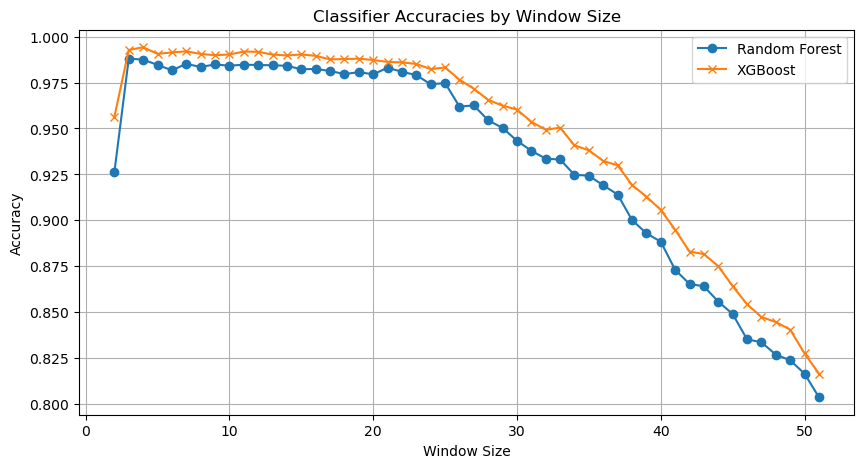

Average RF Accuracy: 0.9342
Average XGBoost Accuracy: 0.9461


In [7]:
# Function to evaluate and plot classifier accuracies
def evaluate_and_plot_accuracies(window_sizes, lccdata_folder, trial_number_for_tuned_hyperparameters):
    rf_accuracies = []
    xgb_accuracies = []
    mode_hyperparameters = get_mode_hyperparameters(trial_number_for_tuned_hyperparameters)
    
    for window_size in window_sizes:
        X_train, X_test, y_train, y_test = prepare_data_x(wt_dict, D132H_dict, window_size)

        # RandomForestClassifier with default hyperparameters
        rf_clf = RandomForestClassifier()
        rf_clf.fit(X_train, y_train)
        rf_predictions = rf_clf.predict(X_test)
        rf_accuracy = accuracy_score(y_test, rf_predictions)
        rf_accuracies.append(rf_accuracy)

        # XGBoostClassifier with mode hyperparameters
        xgb_clf = XGBClassifier(**mode_hyperparameters)
        xgb_clf.fit(X_train, y_train)
        xgb_predictions = xgb_clf.predict(X_test)
        xgb_accuracy = accuracy_score(y_test, xgb_predictions)
        xgb_accuracies.append(xgb_accuracy)

    # Plotting the accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(window_sizes, rf_accuracies, label='Random Forest', marker='o')
    plt.plot(window_sizes, xgb_accuracies, label='XGBoost', marker='x')
    plt.xlabel('Window Size')
    plt.ylabel('Accuracy')
    plt.title('Classifier Accuracies by Window Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print average accuracies
    print(f"Average RF Accuracy: {np.mean(rf_accuracies):.4f}")
    print(f"Average XGBoost Accuracy: {np.mean(xgb_accuracies):.4f}")

window_sizes = range(2, 52)
evaluate_and_plot_accuracies(window_sizes, lccdata_folder, trial_number_for_tuned_hyperparameters=1)

# Saved Position Assessment

In [8]:
# Feature selection consistency comparison
models = ['XGB_Tuned', 'RF']
n_trials = 5
window_sizes = range(2, 52)
threshold = 0.0285
results = {model: {i: 0 for i in range(1, 6)} for model in models}

def weighted_threshold(window_size):
    return threshold * (68 / (70 - window_size))

def count_positions_above_threshold(model, window_size, threshold):
    positions_above_threshold = []
    for trial in range(1, n_trials + 1):
        folder_name = f'{model}_Consistency_Trial_{trial}'
        file_name = f'Feature_Importance_WS_{window_size}.csv'
        file_path = os.path.join(folder_name, file_name)
        
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            positions_above_threshold.append(df[df['0'] > threshold].index.tolist())
        else:
            # Handle missing file if necessary
            pass
    
    # Count positions saved in all 5, 4, 3, 2, and 1 trials
    all_positions = set(sum(positions_above_threshold, []))
    for position in all_positions:
        counts = sum(position in trial_positions for trial_positions in positions_above_threshold)
        results[model][counts] += 1

for model in models:
    for window_size in window_sizes:
        w_threshold = weighted_threshold(window_size)
        count_positions_above_threshold(model, window_size, w_threshold)

# Results
for model in models:
    print(f'{model} Consistency:')
    for k, v in results[model].items():
        print(f'{k}/5 Trials: {v} positions')

XGB_Tuned Consistency:
1/5 Trials: 16 positions
2/5 Trials: 10 positions
3/5 Trials: 12 positions
4/5 Trials: 12 positions
5/5 Trials: 139 positions
RF Consistency:
1/5 Trials: 17 positions
2/5 Trials: 14 positions
3/5 Trials: 14 positions
4/5 Trials: 19 positions
5/5 Trials: 160 positions


# Consistency Assessment

In [12]:
def calculate_consistency_score(consistency_counts):
    """
    Calculate the consistency score for feature selection across trials.
    
    Args:
    - consistency_counts (dict): A dictionary where keys are the number of trials (1 to 5)
      a feature appears in, and values are the number of positions that appear in that many trials.
    
    Returns:
    - float: The calculated consistency score.
    """
    # Initialize total counts and weighted sum
    total_counts = sum(consistency_counts.values())
    weighted_sum = sum(key * value for key, value in consistency_counts.items())
    
    # Calculate the consistency score as the weighted sum of positions divided by the total counts
    consistency_score = weighted_sum / total_counts if total_counts else 0
    
    return consistency_score

# Consistency data for XGBoost and RF
xgb_consistency = {1: 9, 2: 10, 3: 11, 4: 8, 5: 143}
rf_consistency = {1: 17, 2: 14, 3: 14, 4: 19, 5: 160}

# Calculate consistency scores
xgb_consistency_score = calculate_consistency_score(xgb_consistency)
rf_consistency_score = calculate_consistency_score(rf_consistency)

print(f"XGBoost Consistency Score: {xgb_consistency_score:.4f}")
print(f"RF Consistency Score: {rf_consistency_score:.4f}")

XGBoost Consistency Score: 4.4696
RF Consistency Score: 4.2991
